# Systems and Tool Chains for AI Engineers Course Project - Option 1 (FIFA)

## Imports

In [1]:
import os

# PySpark
import pyspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, Imputer, StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StandardScaler

# Data Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from streaming.base.converters.dataframe_to_mds import dataframe_to_mds
import streaming
from streaming import StreamingDataset

# ML Libraries
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import *
import torch
from torch.utils.data import DataLoader
from torch import nn

/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Task 1 - Build and populate necessary tables

In [2]:
appName = "FIFA"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/13 17:40:48 WARN Utils: Your hostname, MacBook-Sir.local, resolves to a loopback address: 127.0.0.1; using 192.168.68.58 instead (on interface en0)
25/11/13 17:40:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 17:40:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/13 17:40:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
year_file_gender = [
    (2015, "Project FIFA Dataset/players_15.csv", "Male"),
    (2016, "Project FIFA Dataset/players_16.csv", "Male"),
    (2017, "Project FIFA Dataset/players_17.csv", "Male"),
    (2018, "Project FIFA Dataset/players_18.csv", "Male"),
    (2019, "Project FIFA Dataset/players_19.csv", "Male"),
    (2020, "Project FIFA Dataset/players_20.csv", "Male"),
    (2021, "Project FIFA Dataset/players_21.csv", "Male"),
    (2022, "Project FIFA Dataset/players_22.csv", "Male"),
    (2016, "Project FIFA Dataset/female_players_16.csv", "Female"),
    (2017, "Project FIFA Dataset/female_players_17.csv", "Female"),
    (2018, "Project FIFA Dataset/female_players_18.csv", "Female"),
    (2019, "Project FIFA Dataset/female_players_19.csv", "Female"),
    (2020, "Project FIFA Dataset/female_players_20.csv", "Female"),
    (2021, "Project FIFA Dataset/female_players_21.csv", "Female"),
    (2022, "Project FIFA Dataset/female_players_22.csv", "Female")
]

all_dfs_appended = []
for year, path, gender in year_file_gender:
    df = (sqlContext.read.format("csv")
            .option("header", "true")
            .option("inferSchema", "true")
            .option("samplingRatio", "1.0")
            .load(path)
            .withColumn("gender", F.lit(gender))
            .withColumn("year", F.lit(year)))
    all_dfs_appended.append(df)

df_all = None
for df in all_dfs_appended:
    if df_all is None:
        df_all = df
    else:
        df_all = df_all.unionByName(df)
df_all.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: long (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: long (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: long (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- natio

In [4]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="localhost"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']="fifa.player_data"
db_properties['driver']="org.postgresql.Driver"

# Write
df_all.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("driver", db_properties['driver'])\
.save()

25/11/13 17:40:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# Read
df_read_all = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("driver", db_properties['driver'])\
    .load()

# df_read_all.show()

In [6]:
# Creating Male only dataframe from dataframe that contains both Male and Female
male_df = df_read_all.filter(F.col('gender') == 'Male')

In [7]:
male_props={}
male_props['username']="postgres"
male_props['password']="localhost"
male_props['url']= "jdbc:postgresql://localhost:5432/postgres"
male_props['table'] = 'fifa.male_player_data'
male_props['driver']="org.postgresql.Driver"

male_df.write.format("jdbc")\
.mode("overwrite")\
.option("url", male_props['url'])\
.option("dbtable", male_props['table'])\
.option("user", male_props['username'])\
.option("password", male_props['password'])\
.option("driver", male_props['driver'])\
.save()

In [8]:
df_male = sqlContext.read.format("jdbc")\
    .option("url", male_props['url'])\
    .option("dbtable", male_props['table'])\
    .option("user", male_props['username'])\
    .option("password", male_props['password'])\
    .option("driver", male_props['driver'])\
    .load()

df_male.printSchema()
df_male.show()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: long (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: long (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: long (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- natio

## Task 2 - Conduct analytics the dataset

### 1. Function to find number of Clubs that had the highest number of Players with contracts ending during $or$ after given Year

In [ ]:
def get_top_clubs():
    while True:
        try:
            X = int(input("Enter the year (2015-2022): "))
            if X >= 2015 and X <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    while True:
        try:
            Y = int(input("Enter the number of clubs: "))
            if Y > 0:
                break
            else:
                print("Number of clubs must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    while True:
        try:
            Z = int(input("Enter the year (2023+): "))
            if Z >= 2023:
                break
            else:
                print("Year must be or after 2023.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    print(f"\n{'='*46}")
    print(f"CONTRACT END YEAR OR AFTER: {Z}")
    print(f"{'='*46}")
    # Filtering the dataframe for the given year and contract end year or after
    df_filtered = df_male.filter((F.col("year") == X))
    df_filtered = df_filtered.filter((F.col("club_contract_valid_until") >= Z))
    df_grouped = df_filtered.groupBy("club_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())

    print(f"Top {Y} clubs")
    print(f"{'='*46}")
    df_result = df_sorted.limit(Y)
    if df_result is not None:
        df_result.show(truncate=False)
    else:
        print("No clubs found")

get_top_clubs()


### 2. Function to find number of Clubs with the highest or lowest average Player age for a given Year

In [23]:
def get_clubs_by_average_age():
    while True:
        try:
            X = int(input("Enter the number of clubs to display: "))
            if X > 0:
                break
            else:
                print("Number of clubs must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    while True:
        try:
            Y = int(input("Enter the year (2015-2022): "))
            if Y >= 2015 and Y <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    while True:
        order_type = input("HIGHEST or LOWEST average age?: ")
        if order_type.lower() == "highest" or order_type.lower() == "lowest":
            break
        else:
            print("Invalid input. Please enter 'Highest' or 'Lowest'.")
    # Checking if the order type is highest or lowest
    if order_type.lower() == "highest":
                # Filtering the dataframe for the given year and sort by the average age in descending order
                df_filtered = df_male.filter((F.col("year") == Y))
                # Grouping the dataframe by the club name and calculating the average age and the number of players
                df_avg_age = df_filtered.groupBy("club_name").agg(
                F.avg("age").alias("avg_age"),
                F.count("age").alias("player_count"))
                # Sorting the dataframe by the average age in descending order
                df_sorted = df_avg_age.orderBy(F.col("avg_age").desc(), F.col("club_name").asc())
                #Considering equal average results on last row
                cutoff_row = df_sorted.limit(X).collect()[-1]
                cutoff_age = cutoff_row["avg_age"]
                df_result = df_sorted.filter(F.col("avg_age") >= cutoff_age)
                
                print(f"\n=== Top {X} clubs ===") 
                print(f"\nSorted by highest average age:") 
                df_result.select("club_name", "avg_age").show(truncate=False)

    else:
        df_filtered = df_male.filter((F.col("year") == Y))
        # Grouping the dataframe by the club name and calculating the average age and the number of players
        df_avg_age = df_filtered.groupBy("club_name").agg(
        F.avg("age").alias("avg_age"),
        F.count("age").alias("player_count"))
        # Sorting the dataframe by the average age in ascending order
        df_sorted = df_avg_age.orderBy(F.col("avg_age").asc(), F.col("club_name").asc())
        #Considering equal average results on last row
        cutoff_row = df_sorted.limit(X).collect()[-1]
        cutoff_age = cutoff_row["avg_age"]
        df_result = df_sorted.filter(F.col("avg_age") <= cutoff_age)

        print(f"\n=== Top {X} clubs ===") 
        print(f"\nSorted by lowest average age:") 
        df_result.select("club_name", "avg_age").show(truncate=False)

get_clubs_by_average_age()


=== Top 25 clubs ===

Sorted by lowest average age:
+--------------------------+------------------+
|club_name                 |avg_age           |
+--------------------------+------------------+
|Bolton Wanderers          |20.26086956521739 |
|UCD AFC                   |20.428571428571427|
|FC Bayern München II      |20.892857142857142|
|FC Nordsjælland           |20.96153846153846 |
|Barnsley                  |21.566666666666666|
|Godoy Cruz                |21.607142857142858|
|Fortuna Sittard           |21.68             |
|SC Heerenveen             |21.695652173913043|
|Futebol Clube de Famalicão|22.291666666666668|
|AFC Wimbledon             |22.392857142857142|
|FC Würzburger Kickers     |22.428571428571427|
|RB Leipzig                |22.454545454545453|
|Silkeborg IF              |22.48148148148148 |
|Brentford                 |22.533333333333335|
|Waasland-Beveren          |22.53846153846154 |
|OGC Nice                  |22.551724137931036|
|KRC Genk                  |22.5714

### 3. Most Popular Nationality for each Year

In [24]:
def get_most_popular_nationality():
    while True:
        try:
            year = int(input("Enter the year (2015-2022): "))
            if year >= 2015 and year <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    # Filtering the dataframe for the given year
    df_filtered = df_male.filter(F.col("year") == year)
    # Grouping the dataframe by the nationality and counting the number of players
    df_grouped = df_filtered.groupBy("nationality_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())
    # Displaying the most popular nationality
    df_sorted.show(1, truncate=False)

get_most_popular_nationality()

+----------------+-----+
|nationality_name|count|
+----------------+-----+
|England         |1627 |
+----------------+-----+
only showing top 1 row


### 4. Histogram of Player Nationalities across all Years

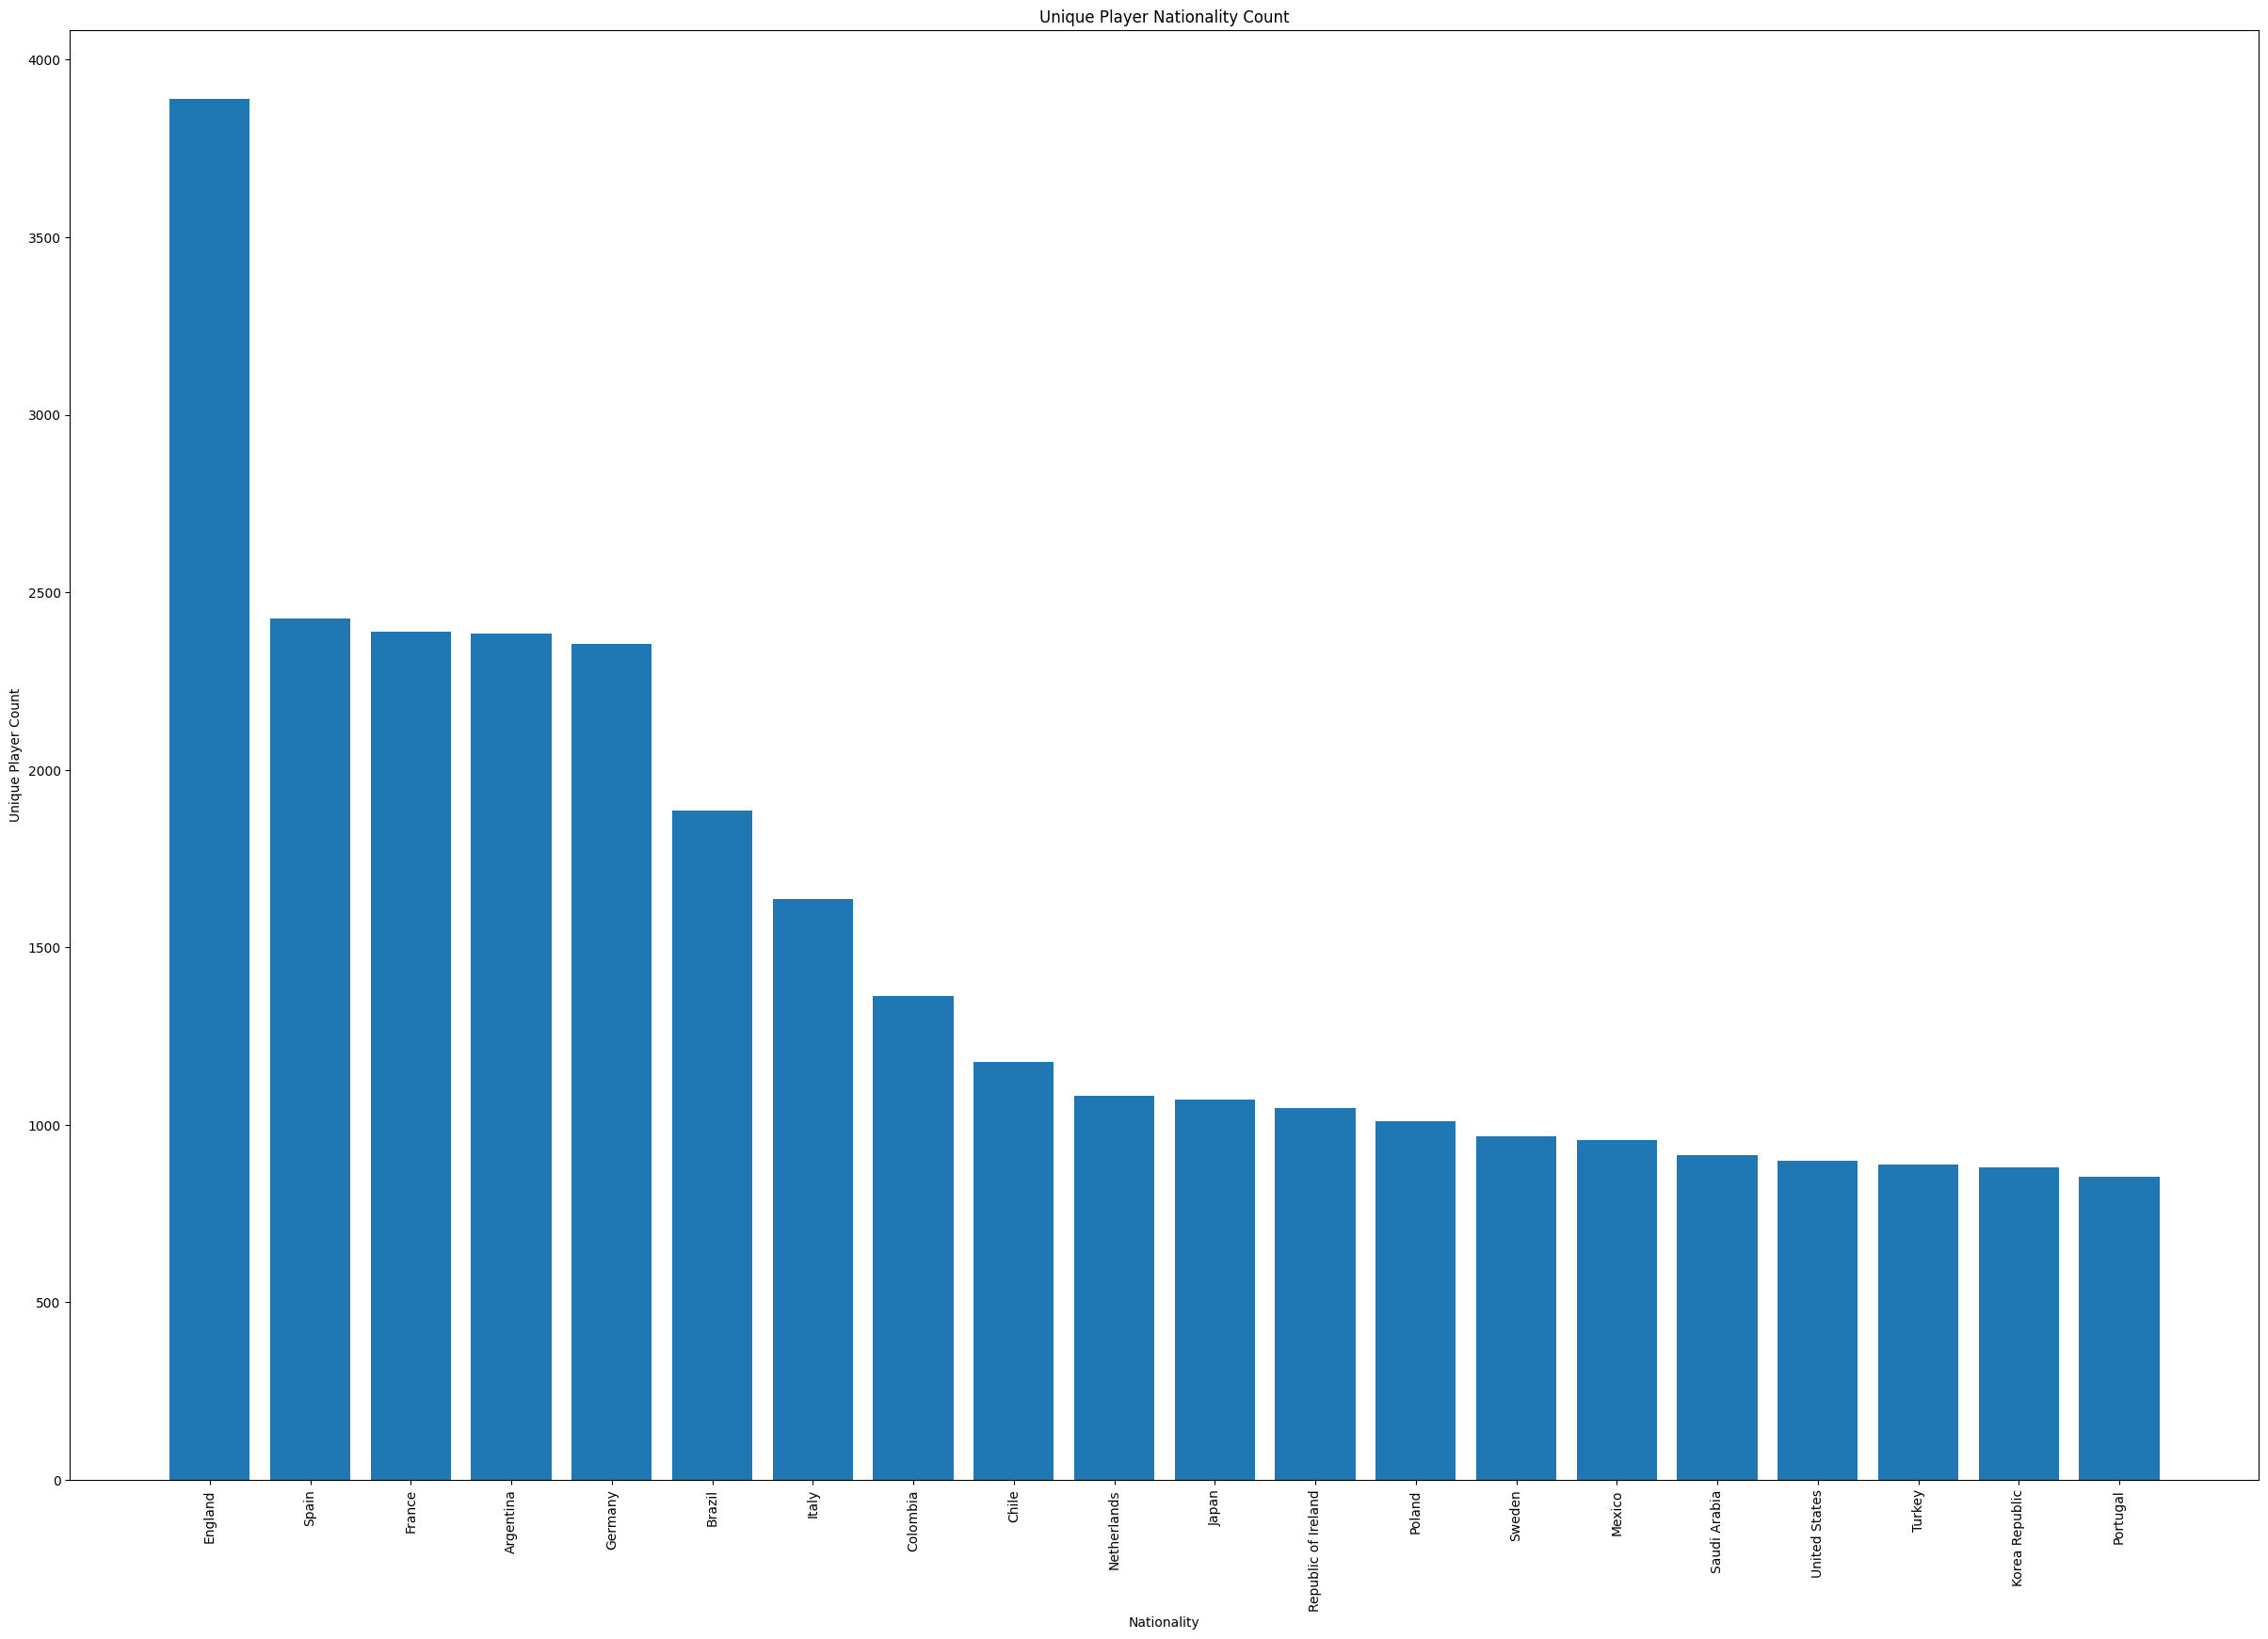

In [25]:
def get_player_nationality_histogram():
    while True:
        try:
            topX = int(input("Enter the number of top nationalities to display: "))
            if topX > 0:
                break
            else:
                print("Number of top nationalities must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    # Filtering the dataframe for the nationality name
    df_filtered = df_male.select("sofifa_id", "nationality_name")
    # De-duplicating the dataframe
    df_filtered = df_filtered.distinct()
    # Grouping the dataframe by the nationality name and counting the number of players
    df_grouped = df_filtered.groupBy("nationality_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())
    # Limiting the dataframe to the top X nationalities
    tX  = df_sorted.limit(topX).collect()
    counts = [row["count"] for row in tX]
    nationalitys = [row["nationality_name"] for row in tX]
    # Plotting the histogram
    plt.figure(figsize=(30, 20))
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Nationality')
    plt.ylabel('Unique Player Count')
    plt.title('Unique Player Nationality Count')
    plt.xticks(range(len(nationalitys)), nationalitys)
    plt.xticks(rotation=90)

    plt.show()

get_player_nationality_histogram()

### 5. Find popular players in YouTube video comments

Please refer to the project's producer and consumer python files for this task.

## Task 3 - Machine Learning Modeling

In [30]:
df_male.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: long (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: long (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: long (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- natio

### Remove features that do not possess predictive signal - Not indicative of skillset or overall value

In [31]:
# Player identification and names
player_info_cols = [
    "sofifa_id", "player_url", "short_name", "long_name", "player_positions", "gender"
]

# Club and league information
club_info_cols = [
    "club_name", "league_name", "club_position", "club_loaned_from", "club_team_id",  "league_level",
    "club_joined", "club_contract_valid_until", "release_clause_eur", "club_jersey_number"
]

# Nationality and nation information
nationality_cols = [
    "nationality_name", "nation_position", "nation_jersey_number", "nationality_id", "nation_team_id"
]

# URL columns (images and logos)
url_cols = [
    "player_face_url", "club_logo_url", "club_flag_url",
    "nation_logo_url", "nation_flag_url"
]

# Date columns
date_cols = [
    "dob", "club_contract_expires", "contract_type", "contract_expires_on", "year"
]

# Player attributes and traits
player_attr_cols = [
    "real_face", "player_tags", "player_traits",
    "international_reputation", "age", "preferred_foot",
    "ls", "st", "rs", "lw", "lf", "cf", "rf",
    "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", "lwb", "ldm", 
    "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
]

columns_to_drop = (
    player_info_cols +
    club_info_cols +
    nationality_cols +
    url_cols +
    date_cols +
    player_attr_cols
)

df_dropped = df_male.drop(*columns_to_drop)
df_dropped.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_short_passing: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_dribbling: integer (nullable = true)
 |-- skill_curve: integ

### Counting Missing Values

In [32]:
# Numeric columns that remain in df_dropped after dropping irrelevant features
numeric_cols = [
    "overall", "value_eur", "wage_eur", "height_cm", "weight_kg", "weak_foot", "skill_moves", 
    "pace", "shooting", "passing", "dribbling",
    "defending", "physic", "attacking_crossing", "attacking_finishing",
    "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys",
    "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing",
    "skill_ball_control", "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_reactions", "movement_balance", "power_shot_power",
    "power_jumping", "power_stamina", "power_strength", "power_long_shots",
    "mentality_aggression", "mentality_interceptions", "mentality_positioning",
    "mentality_vision", "mentality_penalties", "mentality_composure",
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"
]

# Text columns that remain in df_dropped after dropping irrelevant features
text_cols = ["work_rate", "body_type"]

total_rows = df_dropped.count()

null_df = df_dropped.select(
    *[count(when(col(c).isNull(), 1)).alias(c) for c in numeric_cols],
    *[count(when(col(c).isNull() | ((col(c))=="") | upper((col(c))).isin("NA","N/A","NULL"), 1)).alias(c) for c in text_cols]
)

nulls_row_list = null_df.collect()
if nulls_row_list:
    nulls_row = nulls_row_list[0]
    print(f"{'Column':30} | {'# Missing':10} | {'% Missing':10}")
    print("=" * 57)
    every_col = numeric_cols + text_cols
    for c in every_col:
        missing = nulls_row[c]
        percent = (missing / total_rows * 100)
        print(f"{c:30} | {missing:10} | {percent:9.2f}%")

Column                         | # Missing  | % Missing 
overall                        |          0 |      0.00%
value_eur                      |       1897 |      1.34%
wage_eur                       |       1622 |      1.14%
height_cm                      |          0 |      0.00%
weight_kg                      |          0 |      0.00%
weak_foot                      |          0 |      0.00%
skill_moves                    |          0 |      0.00%
pace                           |      15791 |     11.11%
shooting                       |      15791 |     11.11%
passing                        |      15791 |     11.11%
dribbling                      |      15791 |     11.11%
defending                      |      15791 |     11.11%
physic                         |      15791 |     11.11%
attacking_crossing             |          0 |      0.00%
attacking_finishing            |          0 |      0.00%
attacking_heading_accuracy     |          0 |      0.00%
attacking_short_passing        

In [33]:
# Dropping goalkeeping_speed as it has %88.89 missing values
df_dropped = df_dropped.drop("goalkeeping_speed")
# Dropping potential as it is very similar to overall
df_dropped = df_dropped.drop("potential")
df_dropped.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_short_passing: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_dribbling: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accurac

### Imputation

In [34]:
# Numeric columns in df_dropped
numeric_cols = [
    "overall", "value_eur", "wage_eur", "height_cm", "weight_kg", "weak_foot", "skill_moves",
    "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
    "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
    "skill_fk_accuracy", "skill_long_passing", "skill_ball_control",
    "movement_acceleration", "movement_sprint_speed", "movement_agility",
    "movement_reactions", "movement_balance", "power_shot_power", "power_jumping",
    "power_stamina", "power_strength", "power_long_shots", "mentality_aggression",
    "mentality_interceptions", "mentality_positioning", "mentality_vision",
    "mentality_penalties", "mentality_composure", "defending_marking_awareness",
    "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving",
    "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes"
]

# Text columns in df_dropped
text_cols = ["work_rate", "body_type"]

df_numeric_only = df_dropped.select(*numeric_cols)

null_counts = df_numeric_only.select(*[F.count(when(F.col(c).isNull(), 1)).alias(c) for c in numeric_cols])

# Identify which columns have missing values
columns_to_impute = []
for col_name in numeric_cols:
    null_count = null_counts.select(col_name).collect()[0][0]
    if null_count > 0:
        columns_to_impute.append(col_name)

columns_to_exclude = ["overall"]
columns_to_impute = [c for c in columns_to_impute if c not in columns_to_exclude]

print("\nNull counts BEFORE Imputation:")
print("=" * 30)
null_counts.select(*columns_to_impute).show(truncate=False)

value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = df_numeric_only.fillna(value_not_in_dataset, columns_to_impute)

# Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer(
    inputCols=columns_to_impute,
    outputCols=[f"{c}_imputed" for c in columns_to_impute])\
    .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)

# Drop the old columns without imputation
df_imputed_enhanced = df_imputed.drop(*columns_to_impute)

# Rename the newly imputed columns with the correct names
df_numeric_filled = df_imputed_enhanced
for c in columns_to_impute:
    df_numeric_filled = df_numeric_filled.withColumnRenamed(f"{c}_imputed", c)

print("Null counts AFTER Imputation:")
print("=" * 29)
df_numeric_filled.select(*[F.count(when(F.col(c).isNull(), 1)).alias(c) for c in columns_to_impute]).show(truncate=False)

# Add text_cols back to df_numeric_filled
# CITATION: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.monotonically_increasing_id.html
# I used this to add a unique identifier to each row in the dataframe so I could join the numeric and text columns back together after imputation
df_numeric_filled_with_id = df_numeric_filled.withColumn("row_id", monotonically_increasing_id())
df_text_cols = df_dropped.select(*text_cols).withColumn("row_id", monotonically_increasing_id())

df_fully_imputed = df_numeric_filled_with_id.join(df_text_cols, on="row_id", how="inner").drop("row_id")
df_fully_imputed.show(5)


Null counts BEFORE Imputation:
+---------+--------+-----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|pace |shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+-----+--------+-------+---------+---------+------+-------------------+
|1897     |1622    |15791|15791   |15791  |15791    |15791    |15791 |31778              |
+---------+--------+-----+--------+-------+---------+---------+------+-------------------+

Null counts AFTER Imputation:
+---------+--------+----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|pace|shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+----+--------+-------+---------+---------+------+-------------------+
|0        |0       |0   |0       |0      |0        |0        |0     |0                  |
+---------+--------+----+--------+-------+---------+---------+------+-------------------+



+-------+---------+---------+---------+-----------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+---------+--------+----+--------+-------+---------+---------+------+-------------------+-------------+----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_finishing|attacking_heading_accuracy|attacking_short_passing|attacking_volleys|skill_dribbling|

### Handling Outliers

In [35]:
def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    
    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    # Check if selected_columns is not empty before using reduce()
    if len(selected_columns) > 0:
        df = df.withColumn('total_outliers', reduce(column_add, (df[col] for col in selected_columns)))
    else:
        # If no outlier columns were created, set total_outliers to 0
        df = df.withColumn('total_outliers', F.lit(0))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [36]:
df_fully_imputed.summary().show(truncate=False, vertical=True)

-RECORD 0-----------------------------------------
 summary                     | count              
 overall                     | 142079             
 height_cm                   | 142079             
 weight_kg                   | 142079             
 weak_foot                   | 142079             
 skill_moves                 | 142079             
 attacking_crossing          | 142079             
 attacking_finishing         | 142079             
 attacking_heading_accuracy  | 142079             
 attacking_short_passing     | 142079             
 attacking_volleys           | 142079             
 skill_dribbling             | 142079             
 skill_curve                 | 142079             
 skill_fk_accuracy           | 142079             
 skill_long_passing          | 142079             
 skill_ball_control          | 142079             
 movement_acceleration       | 142079             
 movement_sprint_speed       | 142079             
 movement_agility            | 

In [37]:
df_with_outlier_handling = find_outliers(df_fully_imputed)
df_with_outlier_handling.groupby("total_outliers").count().orderBy(F.col("total_outliers").asc()).show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0|70662|
|             1|45754|
|             2| 6732|
|             3| 2150|
|             4|  657|
|             5|  381|
|             6|  749|
|             7| 1789|
|             8| 3218|
|             9| 3227|
|            10| 2398|
|            11| 1478|
|            12| 1106|
|            13|  966|
|            14|  534|
|            15|  211|
|            16|   66|
|            18|    1|
+--------------+-----+



In [38]:
# Filtering out rows with more than 7 outliers
print(f"Before filtering: {df_with_outlier_handling.count()}")
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=7)
print(f"After filtering: {df_with_substituted_na_and_outliers.count()}")

Before filtering: 142079


After filtering: 128874


### Correlation Matrix

In [39]:
# Correlation matrix
correlation_matrix = df_with_substituted_na_and_outliers.select(*numeric_cols).toPandas().corr()
print(correlation_matrix)

                              overall  value_eur  wage_eur  height_cm  \
overall                      1.000000   0.575844  0.618104   0.073008   
value_eur                    0.575844   1.000000  0.779515   0.024068   
wage_eur                     0.618104   0.779515  1.000000   0.044151   
height_cm                    0.073008   0.024068  0.044151   1.000000   
weight_kg                    0.166468   0.049609  0.084353   0.751115   
weak_foot                    0.215282   0.144747  0.144385  -0.102141   
skill_moves                  0.358602   0.284281  0.251191  -0.306572   
pace                         0.185652   0.170467  0.145111  -0.402299   
shooting                     0.476020   0.302344  0.317734  -0.183343   
passing                      0.668286   0.392478  0.419052  -0.264968   
dribbling                    0.592307   0.381262  0.384242  -0.385619   
defending                    0.318934   0.126606  0.164166   0.221489   
physic                       0.506190   0.207003  0

In [40]:
# Finding high correlation pairs
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = float(correlation_matrix.iloc[i, j])
        if np.abs(corr) >= threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr
            })

high_corr_pairs.sort(key=lambda x: np.abs(x['correlation']), reverse=True)

if len(high_corr_pairs) > 0:
    print(f"\n{'Feature 1':40} {'Feature 2':40} {'Correlation':10}")
    print("=" * 100)
    for pair in high_corr_pairs:
        print(f"{pair['feature1']:40} {pair['feature2']:40} {pair['correlation']:10}")
else:
    print("No high correlation pairs")


Feature 1                                Feature 2                                Correlation
defending_standing_tackle                defending_sliding_tackle                 0.9662081664366368
defending                                defending_standing_tackle                0.9388177711125382
pace                                     movement_sprint_speed                    0.9302897734725706
defending                                defending_marking_awareness              0.9282034184857219
defending                                defending_sliding_tackle                 0.9271996491985206
mentality_interceptions                  defending_standing_tackle                0.9241660321766271
defending                                mentality_interceptions                  0.9216103939243738
defending_marking_awareness              defending_standing_tackle                0.9212550447421719
pace                                     movement_acceleration                    0.9210928148071

In [41]:
# Dropping features with high correlation with other features
df_with_handled_correlations_and_dropped_features = df_with_substituted_na_and_outliers.drop("goalkeeping_reflexes", 
                                        "movement_acceleration", "movement_sprint_speed", 
                                        "defending_standing_tackle", "defending_sliding_tackle",
                                        "mentality_interceptions", "goalkeeping_handling", "goalkeeping_positioning"
                                        "goalkeeping_kicking", "goalkeeping_handling", "goalkeeping_diving",
                                        "attacking_finishing", "attacking_short_passing", "attacking_volleys",
                                        "defending_marking_awareness", "skill_dribbling", "power_long_shots",
                                        "skill_ball_control", "power_shot_power", "mentality_vision",
                                        "dribbling", "skill_long_passing", "goalkeeping_positioning",
                                        "power_strength", "movement_reactions"
                                        )

# We iterated through this process of adding features to the list of features to drop and then 
# checking if there are any remaining correlations with correlation coefficient greater than 0.8 multiple times 
# to drop features with high correlation with other features. The above list is the final list of features that we dropped.

# Checking if there are any remaining correlations with correlation coefficient greater than 0.8
numeric_cols_with_dropped_features = [c for c in numeric_cols if c in df_with_handled_correlations_and_dropped_features.columns]

correlation_matrix_with_dropped_features = df_with_handled_correlations_and_dropped_features\
    .select(*numeric_cols_with_dropped_features).toPandas().corr()

threshold = 0.8
high_corr_pairs_with_dropped_features = []

for i in range(len(correlation_matrix_with_dropped_features.columns)):
    for j in range(i+1, len(correlation_matrix_with_dropped_features.columns)):
        corr = float(correlation_matrix_with_dropped_features.iloc[i, j])
        if np.abs(corr) >= threshold:
            high_corr_pairs_with_dropped_features.append({
                'feature1': correlation_matrix_with_dropped_features.columns[i],
                'feature2': correlation_matrix_with_dropped_features.columns[j],
                'correlation': corr
            })

high_corr_pairs_with_dropped_features.sort(key=lambda x: np.abs(x['correlation']), reverse=True)

if len(high_corr_pairs_with_dropped_features) > 0:
    print(f"\n{'Feature 1':40} {'Feature 2':40} {'Correlation':10}")
    print("=" * 100)
    for pair in high_corr_pairs_with_dropped_features:
        print(f"{pair['feature1']:40} {pair['feature2']:40} {pair['correlation']:10}")
else:
    print("No high correlation pairs")

No high correlation pairs


In [42]:
df_with_handled_correlations_and_dropped_features = df_with_handled_correlations_and_dropped_features.drop("total_outliers")
df_with_handled_correlations_and_dropped_features.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accuracy: integer (nullable = true)
 |-- movement_agility: integer (nullable = true)
 |-- movement_balance: integer (nullable = true)
 |-- power_jumping: integer (nullable = true)
 |-- power_stamina: integer (nullable = true)
 |-- mentality_aggression: integer (nullable = true)
 |-- mentality_positioning: integer (nullable = true)
 |-- mentality_penalties: integer (nullable = true)
 |-- goalkeeping_kicking: integer (nullable = true)
 |-- value_eur: double (nullable = false)
 |-- wage_eur: double (nullable = false)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integ

### Handling Ordinal and Nominal Variables

In [43]:
continuous_cols = ["overall", "height_cm", "weight_kg", "weak_foot", "skill_moves", "attacking_crossing", 
                    "attacking_heading_accuracy", "skill_curve", "skill_fk_accuracy", "movement_agility", 
                    "movement_balance", "power_jumping", "power_stamina", "mentality_aggression", "mentality_positioning", 
                    "mentality_penalties", "goalkeeping_kicking", "value_eur", "wage_eur", "pace", "shooting", "passing", 
                    "defending", "physic", "mentality_composure"]

ordinal_cols = ["work_rate"]

nominal_cols = ["body_type"]

In [44]:
# Ordinal Variables
indexer = StringIndexer(inputCol="work_rate", outputCol="work_rate_index")
df_ordinal_handled = indexer.fit(df_with_handled_correlations_and_dropped_features).transform(df_with_handled_correlations_and_dropped_features)
df_ordinal_handled.show(5)
print("Ordinal Indexed DataFrame:")
# Dropping the original work_rate column
df_ordinal_handled = df_ordinal_handled.drop("work_rate")
print("Ordinal Indexed Dropped DataFrame:")
df_ordinal_handled.show(5)

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+-------------+----------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|    work_rate|       body_type|work_rate_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+---------------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+----------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|       body_type|work_rate_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+

In [45]:
# Nominal Variables
indexer = StringIndexer(inputCol="body_type", outputCol="body_type_index")
df_nominal_handled = indexer.fit(df_ordinal_handled).transform(df_ordinal_handled)
print("Nominal Indexed DataFrame:")
df_nominal_handled.show(5)
# Dropping the original body_type column
df_nominal_handled = df_nominal_handled.drop("body_type")
print("Nominal Indexed Dropped DataFrame:")
df_nominal_handled.show(5)

encoder = OneHotEncoder(inputCols=["body_type_index"], outputCols=["body_type_encoded"])
df_nominal_encoded = encoder.fit(df_nominal_handled).transform(df_nominal_handled)
print("Nominal Encoded DataFrame:")
df_nominal_encoded.show(5)
# Dropping the original body_type_index column
df_nominal_encoded = df_nominal_encoded.drop("body_type_index")
print("Final Nominal Encoded DataFrame:")
df_nominal_encoded.show(5)


Nominal Indexed DataFrame:


+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+----------------+---------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|       body_type|work_rate_index|body_type_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+-----------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+--

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+---------------+-----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_index|body_type_encoded|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+---------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+-----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_encoded|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+--------------------

In [46]:
df_nominal_encoded.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accuracy: integer (nullable = true)
 |-- movement_agility: integer (nullable = true)
 |-- movement_balance: integer (nullable = true)
 |-- power_jumping: integer (nullable = true)
 |-- power_stamina: integer (nullable = true)
 |-- mentality_aggression: integer (nullable = true)
 |-- mentality_positioning: integer (nullable = true)
 |-- mentality_penalties: integer (nullable = true)
 |-- goalkeeping_kicking: integer (nullable = true)
 |-- value_eur: double (nullable = false)
 |-- wage_eur: double (nullable = false)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integ

### Vector Assembly

In [47]:
feature_list = df_nominal_encoded.drop("overall").columns
print("Feature List:")
for feature in feature_list:
    print(feature)

vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_nominal_encoded.withColumn("label", col("overall")))

Feature List:
height_cm
weight_kg
weak_foot
skill_moves
attacking_crossing
attacking_heading_accuracy
skill_curve
skill_fk_accuracy
movement_agility
movement_balance
power_jumping
power_stamina
mentality_aggression
mentality_positioning
mentality_penalties
goalkeeping_kicking
value_eur
wage_eur
pace
shooting
passing
defending
physic
mentality_composure
work_rate_index
body_type_encoded


In [48]:
df_with_assembled_features.select("vectorized_features","label")\
    .distinct().toPandas()

,vectorized_features,label
0,"[178.0, 72.0, 2.0, 2.0, 64.0, 62.0, 62.0, 34.0...",71
1,"[176.0, 74.0, 3.0, 3.0, 67.0, 55.0, 66.0, 52.0...",69
2,"[180.0, 69.0, 3.0, 3.0, 66.0, 53.0, 70.0, 73.0...",65
3,"[181.0, 77.0, 3.0, 3.0, 71.0, 51.0, 60.0, 66.0...",68
4,"[191.0, 86.0, 3.0, 2.0, 68.0, 84.0, 44.0, 42.0...",84
...,...,...
128694,"[168.0, 61.0, 3.0, 2.0, 51.0, 54.0, 42.0, 49.0...",56
128695,"[171.0, 63.0, 2.0, 2.0, 35.0, 52.0, 49.0, 32.0...",59
128696,"[185.0, 87.0, 2.0, 2.0, 81.0, 68.0, 58.0, 70.0...",75
128697,"[182.0, 75.0, 2.0, 2.0, 45.0, 48.0, 46.0, 45.0...",55


### Data Scaling

In [49]:
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("features", "label").distinct().toPandas()

,features,label
0,"[27.138149075246027, 11.345193069047763, 4.711...",73
1,"[28.2175072771024, 11.643750781391127, 3.14086...",66
2,"[29.14267145012215, 12.24086620607785, 4.71130...",65
3,"[27.754925190592527, 10.598798788189358, 4.711...",72
4,"[24.36265655618677, 10.150962219674314, 6.2817...",67
...,...,...
128694,"[29.451059507795403, 11.046635356704401, 4.711...",69
128695,"[29.296865478958775, 11.942308493734489, 3.140...",72
128696,"[27.90911921942915, 11.046635356704401, 4.7113...",68
128697,"[26.212984902226275, 10.001683363502634, 6.281...",65


## Model Training

### Spark

In [51]:
# Data Split
train_data, test_data = df_with_scaled_features.randomSplit([0.8, 0.2], seed= 13)

#### Model 1: Random Forest

In [53]:
# Create Regression Evaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
)

# Parameter Grid for Hyperparameter Tuning
rf_param_grid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20])
    .addGrid(rf.maxDepth, [5, 10])
    .build()
)

# CrossValidator for Hyperparameter Tuning
rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4,
    seed=13
)

# Train the model with cross-validation on training data
rf_cv_model = rf_cv.fit(train_data)

# Get the best model from cross-validation
best_model = rf_cv_model.bestModel # Citation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidatorModel.html

# Best Model
best_rf_model = best_model
print(f"Best model parameters:")
print(f"Number of Trees: {best_rf_model.getNumTrees}")
print(f"Max Depth: {best_rf_model.getMaxDepth()}")

# Test evaluation
rf_test_predictions = best_rf_model.transform(test_data)
test_rmse = evaluator.evaluate(rf_test_predictions)
print(f"Test RMSE: {test_rmse:.4f}")

25/11/13 19:55:02 WARN CacheManager: Asked to cache already cached data.) / 200]
25/11/13 19:55:02 WARN CacheManager: Asked to cache already cached data.
25/11/13 19:56:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/11/13 19:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1957.5 KiB
25/11/13 20:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1208.1 KiB
25/11/13 20:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1190.0 KiB
25/11/13 20:03:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/13 20:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1957.6 KiB
25/11/13 20:04:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/11/13 20:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1210.9 KiB
25/11/13 20:07:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/13 20:07:56 WARN DAGScheduler: Broadcasting large t

Best model parameters:
Number of Trees: 20
Max Depth: 10


Test RMSE: 1.3398


#### Model 2: Linear Regression

In [54]:
# Create Regression Evaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Initialize Linear Regression
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
)

# Parameter Grid for Hyperparameter Tuning
lr_param_grid = (ParamGridBuilder()
    .addGrid(lr.maxIter, [5, 10])
    .addGrid(lr.regParam, [0.00001, 0.0001])
    .build()
)

# CrossValidator for Hyperparameter Tuning
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4,
    seed=13
)

# Train the model with cross-validation on training data
lr_cv_model = lr_cv.fit(train_data)

# Get the best model from cross-validation
best_model = lr_cv_model.bestModel # Citation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidatorModel.html

# Best Model
best_lr_model = best_model
print(f"Best model parameters:")
print(f"maxIter: {best_lr_model.getMaxIter()}")
print(f"regParam: {best_lr_model.getRegParam()}")

# Test evaluation
lr_test_predictions = best_lr_model.transform(test_data)
test_rmse = evaluator.evaluate(lr_test_predictions)
print(f"Test RMSE: {test_rmse:.4f}")

25/11/13 20:12:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/13 20:12:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Best model parameters:
maxIter: 5
regParam: 1e-05


Test RMSE: 3.0738


### PyTorch

In [55]:
# Data Split
py_train_data, py_val_data, py_test_data = df_with_scaled_features.randomSplit([0.7, 0.15, 0.15], seed= 13)

In [56]:
# Define the function that write the Spark DataFrame to files using `mosaic-streaming`
def write_df_to_mds(outpath,dataframe):
    # Convert the Spark DataFrame to a format that can be written to MDS, mainliy converting the vector column to array column
    dataframe_converted = dataframe.withColumn("features", vector_to_array("features"))\
                                   .withColumn("features",col("features").cast(ArrayType(FloatType(), True)))\
                                   .withColumn("label",col("label").cast(LongType()))
    mds_kwargs = {
    "out": outpath,
    "columns": {"features": "ndarray:float32", "label": "int64"}
    }
    dataframe_to_mds(
        dataframe_converted,
        mds_kwargs = mds_kwargs
    )

write_df_to_mds("/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds", py_train_data)
write_df_to_mds("/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/test_mds", py_test_data)
write_df_to_mds("/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/val_mds", py_val_data)

Path /Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds is interpreted as a local path. If this is actually mounted distributed storage, it will work, but consider also specifying a local temp path. Pass a (local, remote) tuple as "out", as in ("/local_disk0/my_tmp", "/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds")
/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Directory /Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds exists and not empty. But continue to mkdir since exist_ok is set to be True.


#### Model 1: Multi-Layer Perceptron (Deep - 4 Hidden Layers)

In [58]:
class RegressionMLPDeep(nn.Module):
    def __init__(self, input_dim=34):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [59]:
os.environ['PYTHONWARNINGS'] = 'ignore'

# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.001, 0.005],
    'batch_size': [64, 128],
    'N_epochs': [10]
}

# Create loss function
loss_fun = nn.MSELoss()

# Track best model
best_overall_val_loss = float('inf')
best_hyperparams = None

for lr in hyperparameter_grid['lr']:
    for batch_size in hyperparameter_grid['batch_size']:
        for N_epochs in hyperparameter_grid['N_epochs']:
            print(f"Training with: lr={lr}, batch_size={batch_size}, epochs={N_epochs}")
            
            # Initialize model for this hyperparameter combination
            mymodel = RegressionMLPDeep()
            
            # Create scalable datasets/dataloaders for training and validation
            train_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds",
            batch_size=batch_size,shuffle=True)

            validate_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/val_mds",
            batch_size=batch_size,shuffle=True)

            test_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/test_mds",
            batch_size=batch_size,shuffle=True)

            train_dataloader = DataLoader(train_dataset_scalable, batch_size = batch_size, num_workers = 1)
            validate_dataloader = DataLoader(validate_dataset_scalable,batch_size = batch_size, num_workers = 1)
            test_dataloader = DataLoader(test_dataset_scalable,batch_size = batch_size, num_workers = 1)

            # Create optimizer
            optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

            losses = [] # training losses of each epoch

            validate_losses = [] # validation losses of each epoch

            current_best_loss = float('inf')

            for epoch in range(N_epochs):
                # Train loop
                batch_loss = [] # keep a list of losses for different batches in this epoch
                for batch_samples in train_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()        
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compute the MSE loss for regression
                    loss = loss_fun(prediction_score,y_batch)

                    # compute the gradient
                    optimizer.zero_grad()
                    loss.backward()

                    # update parameters with optimizer step
                    optimizer.step()

                    # append the loss of this batch to the batch_loss list
                    batch_loss.append(loss.detach().numpy())

                
                # Validation loop
                validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch

                for batch_samples in validate_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()
                    
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compare prediction and the actual output and compute the loss
                    loss = loss_fun(prediction_score,y_batch)

                    # append the loss of this batch to the validate_batch_loss list
                    validate_batch_loss.append(loss.detach())
                
                # calculate the average train loss and validate loss in this epoch and record them
                losses.append(np.mean(np.array(batch_loss)))
                validate_losses.append(np.mean(np.array(validate_batch_loss)))

                # Printing
                print(f"Epoch = {epoch}, Train Loss = {losses[-1]}, Validate Loss = {validate_losses[-1]}")
                print(f"Train RMSE = {np.sqrt(losses[-1]):.4f}, Validation RMSE = {np.sqrt(validate_losses[-1]):.4f}") # Square root of the MSE loss is the RMSE
                
                # If the validate metric of this epoch is the best so far, save the model
                if validate_losses[-1] < current_best_loss:
                    print("Current epoch is the best so far. Saving model...") 
                    torch.save(mymodel.state_dict(),'deep_current_best_model')
                    current_best_loss = validate_losses[-1]
            
            # Check if this is the best hyperparameter combination overall
            if current_best_loss < best_overall_val_loss:
                best_overall_val_loss = current_best_loss
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'N_epochs': N_epochs}
                # Save as the overall best model
                torch.save(mymodel.state_dict(), 'deep_best_model')
                print(f"\n NEW BEST MODEL Val Loss: {best_overall_val_loss:.4f}")

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation loss: {best_overall_val_loss:.4f}")

# Load the best model and evaluate on test data
mymodel = RegressionMLPDeep()
mymodel.load_state_dict(torch.load('deep_best_model'))
mymodel.eval()

# Create test dataloader with best batch_size
test_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/test_mds",
batch_size=best_hyperparams['batch_size'],shuffle=True)
test_dataloader = DataLoader(test_dataset_scalable, batch_size = best_hyperparams['batch_size'], num_workers = 1)

test_losses = []
with torch.no_grad():
    for batch_samples in test_dataloader:
        x_batch = batch_samples['features']
        y_batch = batch_samples['label'].float()
        
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        test_losses.append(loss.item())

test_rmse = np.sqrt(np.mean(np.array(test_losses)))
print(f"\nTest RMSE with best model: {test_rmse:.4f}")

Training with: lr=0.001, batch_size=64, epochs=10


/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensu

Epoch = 0, Train Loss = 99.21495056152344, Validate Loss = 51.14813995361328
Train RMSE = 9.9607, Validation RMSE = 7.1518
Current epoch is the best so far. Saving model...
Epoch = 1, Train Loss = 51.885398864746094, Validate Loss = 50.92462158203125
Train RMSE = 7.2032, Validation RMSE = 7.1361
Current epoch is the best so far. Saving model...
Epoch = 2, Train Loss = 51.21964645385742, Validate Loss = 52.24203109741211
Train RMSE = 7.1568, Validation RMSE = 7.2279
Epoch = 3, Train Loss = 51.666099548339844, Validate Loss = 49.467037200927734
Train RMSE = 7.1879, Validation RMSE = 7.0333
Current epoch is the best so far. Saving model...
Epoch = 4, Train Loss = 51.31295394897461, Validate Loss = 50.18367004394531
Train RMSE = 7.1633, Validation RMSE = 7.0840
Epoch = 5, Train Loss = 51.21061706542969, Validate Loss = 50.43155288696289
Train RMSE = 7.1562, Validation RMSE = 7.1015
Epoch = 6, Train Loss = 51.239112854003906, Validate Loss = 51.614017486572266
Train RMSE = 7.1582, Validatio

/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch = 0, Train Loss = 171.55482482910156, Validate Loss = 51.485198974609375
Train RMSE = 13.0979, Validation RMSE = 7.1753
Current epoch is the best so far. Saving model...
Epoch = 1, Train Loss = 50.65475082397461, Validate Loss = 50.06843566894531
Train RMSE = 7.1172, Validation RMSE = 7.0759
Current epoch is the best so far. Saving model...
Epoch = 2, Train Loss = 50.83623504638672, Validate Loss = 51.23301315307617
Train RMSE = 7.1300, Validation RMSE = 7.1577
Epoch = 3, Train Loss = 50.73725128173828, Validate Loss = 50.22874069213867
Train RMSE = 7.1230, Validation RMSE = 7.0872
Epoch = 4, Train Loss = 50.895320892333984, Validate Loss = 55.781925201416016
Train RMSE = 7.1341, Validation RMSE = 7.4687
Epoch = 5, Train Loss = 50.72468185424805, Validate Loss = 50.20649337768555
Train RMSE = 7.1221, Validation RMSE = 7.0857
Epoch = 6, Train Loss = 50.701499938964844, Validate Loss = 49.72242736816406
Train RMSE = 7.1205, Validation RMSE = 7.0514
Current epoch is the best so far.

/opt/anaconda3/envs/spark_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Test RMSE with best model: 7.0830


#### Model 2: Multi-Layer Perceptron (Shallow - 1 Hidden Layer)

In [62]:
class RegressionMLPSmall(nn.Module):
    def __init__(self, input_dim=34):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [63]:
os.environ['PYTHONWARNINGS'] = 'ignore'

# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.0005, 0.001],
    'batch_size': [64, 128],
    'N_epochs': [5]
}

# Create loss function
loss_fun = nn.MSELoss()

# Track best model
best_overall_val_loss = float('inf')
best_hyperparams = None

for lr in hyperparameter_grid['lr']:
    for batch_size in hyperparameter_grid['batch_size']:
        for N_epochs in hyperparameter_grid['N_epochs']:
            print(f"Training with: lr={lr}, batch_size={batch_size}, epochs={N_epochs}")
            
            # Initialize model for this hyperparameter combination
            mymodel = RegressionMLPSmall()
            
            # Create scalable datasets/dataloaders for training and validation
            train_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/train_mds",
            batch_size=batch_size,shuffle=True)

            validate_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/val_mds",
            batch_size=batch_size,shuffle=True)

            test_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/test_mds",
            batch_size=batch_size,shuffle=True)

            train_dataloader = DataLoader(train_dataset_scalable, batch_size = batch_size, num_workers = 1)
            validate_dataloader = DataLoader(validate_dataset_scalable,batch_size = batch_size, num_workers = 1)
            test_dataloader = DataLoader(test_dataset_scalable,batch_size = batch_size, num_workers = 1)

            # Create optimizer
            optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

            losses = [] # training losses of each epoch

            validate_losses = [] # validation losses of each epoch

            current_best_loss = float('inf')

            for epoch in range(N_epochs):
                # Train loop
                batch_loss = [] # keep a list of losses for different batches in this epoch
                for batch_samples in train_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()        
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compute the MSE loss for regression
                    loss = loss_fun(prediction_score,y_batch)

                    # compute the gradient
                    optimizer.zero_grad()
                    loss.backward()

                    # update parameters with optimizer step
                    optimizer.step()

                    # append the loss of this batch to the batch_loss list
                    batch_loss.append(loss.detach().numpy())

                
                # Validation loop
                validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch

                for batch_samples in validate_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()
                    
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compare prediction and the actual output and compute the loss
                    loss = loss_fun(prediction_score,y_batch)

                    # append the loss of this batch to the validate_batch_loss list
                    validate_batch_loss.append(loss.detach())
                
                # calculate the average train loss and validate loss in this epoch and record them
                losses.append(np.mean(np.array(batch_loss)))
                validate_losses.append(np.mean(np.array(validate_batch_loss)))

                # Printing
                print(f"Epoch = {epoch}, Train Loss = {losses[-1]}, Validate Loss = {validate_losses[-1]}")
                print(f"Train RMSE = {np.sqrt(losses[-1]):.4f}, Validation RMSE = {np.sqrt(validate_losses[-1]):.4f}") # Square root of the MSE loss is the RMSE
                
                # If the validate metric of this epoch is the best so far, save the model
                if validate_losses[-1] < current_best_loss:
                    print("Current epoch is the best so far. Saving model...") 
                    torch.save(mymodel.state_dict(),'shallow_current_best_model')
                    current_best_loss = validate_losses[-1]
            
            # Check if this is the best hyperparameter combination overall
            if current_best_loss < best_overall_val_loss:
                best_overall_val_loss = current_best_loss
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'N_epochs': N_epochs}
                # Save as the overall best model
                torch.save(mymodel.state_dict(), 'shallow_best_model')
                print(f"\n NEW BEST MODEL Val Loss: {best_overall_val_loss:.4f}")

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation loss: {best_overall_val_loss:.4f}")

# Load the best model and evaluate on test data
mymodel = RegressionMLPSmall()
mymodel.load_state_dict(torch.load('shallow_best_model'))
mymodel.eval()

# Create test dataloader with best batch_size
test_dataset_scalable = StreamingDataset(local="/Users/anindithram/Documents/CMU Fall 2025/System and Tool Chains for AI Engineers/Course Project FIles/test_mds",
batch_size=best_hyperparams['batch_size'],shuffle=True)
test_dataloader = DataLoader(test_dataset_scalable, batch_size = best_hyperparams['batch_size'], num_workers = 1)

test_losses = []
with torch.no_grad():
    for batch_samples in test_dataloader:
        x_batch = batch_samples['features']
        y_batch = batch_samples['label'].float()
        
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        test_losses.append(loss.item())

test_rmse = np.sqrt(np.mean(np.array(test_losses)))
print(f"\nTest RMSE with best model: {test_rmse:.4f}")

Training with: lr=0.0005, batch_size=64, epochs=5
Epoch = 0, Train Loss = 889.6898193359375, Validate Loss = 55.31373596191406
Train RMSE = 29.8277, Validation RMSE = 7.4373
Current epoch is the best so far. Saving model...
Epoch = 1, Train Loss = 52.9106559753418, Validate Loss = 51.77860641479492
Train RMSE = 7.2740, Validation RMSE = 7.1957
Current epoch is the best so far. Saving model...
Epoch = 2, Train Loss = 51.32634735107422, Validate Loss = 51.02867889404297
Train RMSE = 7.1642, Validation RMSE = 7.1434
Current epoch is the best so far. Saving model...
Epoch = 3, Train Loss = 50.79269027709961, Validate Loss = 50.43911361694336
Train RMSE = 7.1269, Validation RMSE = 7.1020
Current epoch is the best so far. Saving model...
Epoch = 4, Train Loss = 50.47530746459961, Validate Loss = 50.29415512084961
Train RMSE = 7.1046, Validation RMSE = 7.0918
Current epoch is the best so far. Saving model...

 NEW BEST MODEL Val Loss: 50.2942
Training with: lr=0.0005, batch_size=128, epochs=5